## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
import scipy.sparse as sp
from numba import jit
import squidpy as sq
import models
from sklearn.metrics import accuracy_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
adata = sq.datasets.seqfish()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata


AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined', 'n_counts'
    uns: 'celltype_mapped_refined_colors', 'log1p'
    obsm: 'X_umap', 'spatial'

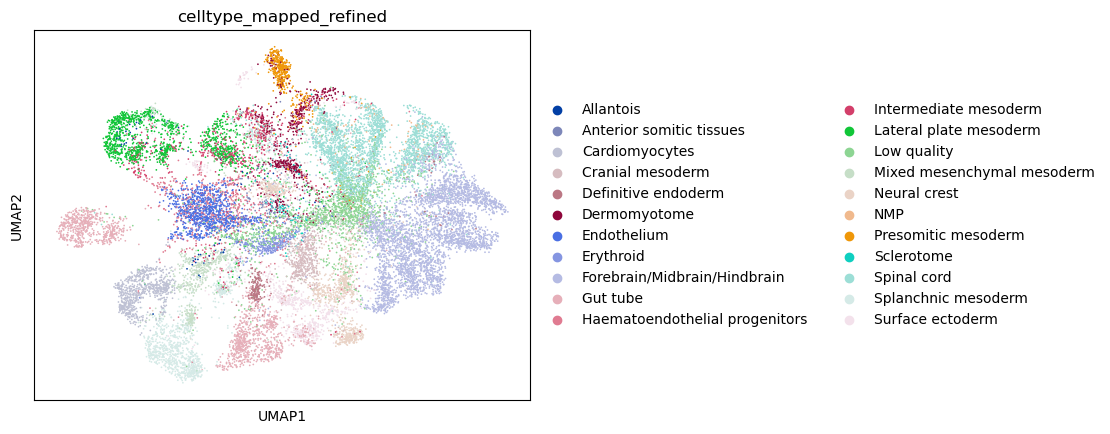

In [3]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype_mapped_refined')

In [4]:
adata.obs['CellType']= adata.obs['celltype_mapped_refined']
celltype_list = list(adata.obs['CellType'].unique())
celltype_list.remove("Low quality")
len(celltype_list)

21

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


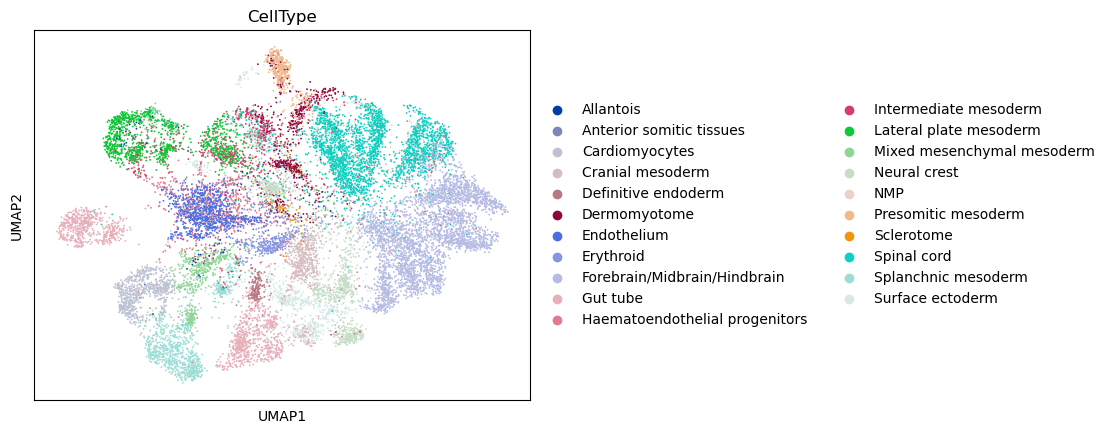

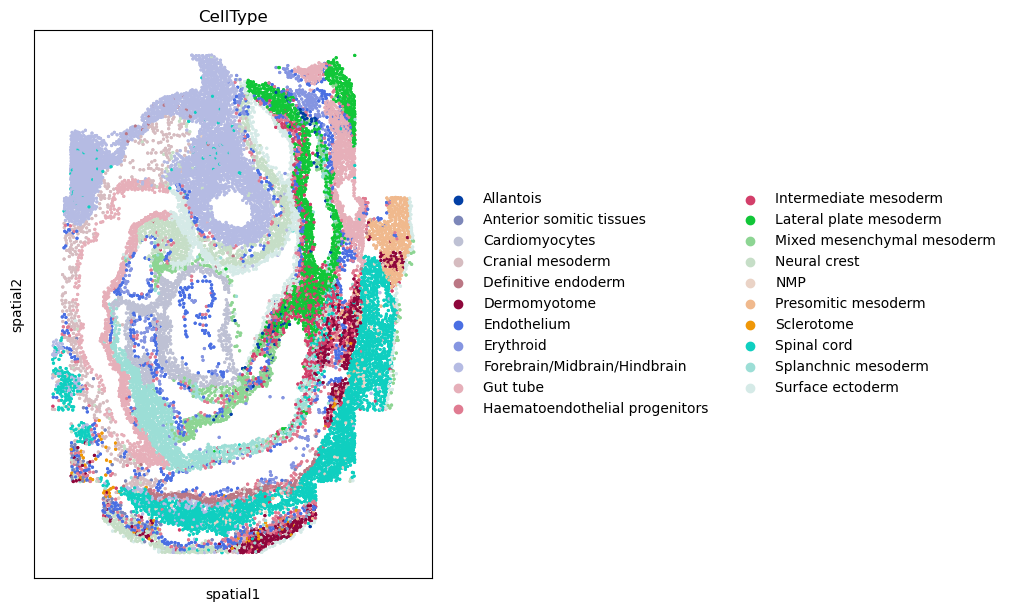

In [5]:
adata= adata[adata.obs['CellType'].isin(celltype_list)]
sc.pl.umap(adata,color='CellType')
sq.pl.spatial_scatter(
    adata, color="CellType", shape=None, figsize=(10, 10)
)


In [6]:
adata

AnnData object with n_obs × n_vars = 17771 × 351
    obs: 'Area', 'celltype_mapped_refined', 'n_counts', 'CellType'
    uns: 'celltype_mapped_refined_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'X_umap', 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
import random
import pandas as pd

def modify_labels(orig_labeles, probability=0.1):
    # Get the list of all possible labels
    all_labels = list(set(orig_labeles))

    # Create a list to store the modified labels
    modified_labels = []

    # Loop over the labels in the dataset
    for label in orig_labeles:
        # Generate a random number between 0 and 1
        r = random.random()

        # If the random number is smaller than the probability,
        # modify the label by choosing a random label from the list of all labels,
        # excluding the original label
        if r < probability:
            modified_label = random.choice([l for l in all_labels if l != label])
        else:
            modified_label = label

        # Add the modified label to the list
        modified_labels.append(modified_label)

    # Create a DataFrame with the original and modified labels
    df = pd.DataFrame({"label": orig_labeles, "modified_label": modified_labels})


    return df , (np.where(df["label"] != df["modified_label"]))

def one_hot_encode(labels):
    """
    One-hot encodes an array of labels.
    
    Args:
        labels (numpy.ndarray): Array of labels.
        
    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    return onehot_encoded, label_encoder



In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier


def multi_ada_sampling(data, label, classifier="svm", percent=1, L=10, prob_output=False, balance=True, iter=3):
    def update_xy(vote_class, label, percent, balance):
        sample_size = int(np.round(np.median(list(Counter(label).values()))))
        idx = []
        if balance:
            idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        else:
            if len(vote_class) > sample_size:
                idx = resample(np.arange(len(vote_class)), n_samples=int(sample_size * percent), replace=True, stratify=vote_class)
            else:
                idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        
        return data[:, idx], label[idx]

    models = []
    for _ in range(L):
        X = data
        Y = label
        model_list = []
        prob_list = []
        
        for _ in range(iter):
            if classifier == "rf":
                model = RandomForestClassifier(n_estimators=100)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier == "svm":
                model = SVC(probability=True)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier =="knn":
                model = KNeighborsClassifier()
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
                #print(prob)
            else:
                raise ValueError(f"Unknown classifier: {classifier}")
            
            X, Y = [], []
            xy_update = []
            for j in range(prob.shape[1]):
                vote_class = prob[label == j]
                xy_update.append(update_xy(vote_class, label, percent, balance))
            
            cur_X = np.column_stack([xy[0] for xy in xy_update])
            cur_Y = np.concatenate([xy[1] for xy in xy_update])
            X, Y = cur_X, cur_Y
        models.append(model)
    
    predict_mat = np.zeros((data.shape[1], len(np.unique(label))))
    final = []
    for model in models:
        if classifier == "svm":
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        else:
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        predict_mat += tmp
    
    if prob_output:
        final = np.max(predict_mat, axis=1)
        final = dict(zip(list(np.unique(label))[np.argmax(predict_mat, axis=1)], final))
    else:
        final = 0#list(np.unique(label))[np.argmax(predict_mat, axis=1)]
    
    return {"final": final, "models": models, "prob": predict_mat}

def get_conf_from_scReClassify(adata, res , formerlabels, L=10):
    prob_mat= res['prob']
    return prob_mat[np.arange(len(prob_mat)), formerlabels]/L



In [9]:
adata.X = adata.X.toarray()

In [10]:
#epoch_num=25

#prob_list = models.follow_training_dyn_neural_net(adata, label_key='CellType',iterNum=epoch_num, device=device)
#all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
#adata.obs['conf']= all_conf
#adata.obs['var']= all_var
#cutoff_conf , cutoff_var = models.find_cutoff_paramter(adata,'CellType',device=device,probability=0.01,percentile=95,epoch_num=epoch_num)
#adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))


In [11]:
#cutoff_conf , cutoff_var

In [12]:
#adata= adata[adata.obs['conf_binaries'].isin([True])]
#adata

In [13]:
adata_copy = adata.copy()


In [14]:
from sklearn.preprocessing import LabelEncoder
epoch_num=20



from sklearn.preprocessing import LabelEncoder
screc_res_list_rf = []
screc_res_list_svm = []
screc_res_list_knn = []
cell_anno_list = []
screc_res_list_rf_var = []
screc_res_list_knn_var = []
screc_res_list_svm_var = []
cell_anno_list_var = []
for i in range(1,6):
    tmp_roc_screc_rf = []
    tmp_roc_screc_knn = []
    tmp_roc_screc_svm = []
    tmp_roc_cell_anno = []
    for j in range(5):
        adata= adata_copy.copy()
        sc.pp.subsample(adata, n_obs=10000)
        labeles = adata.obs['CellType']
        df , were_changed = modify_labels(labeles , probability=0.1*i)
        were_changed_array =np.zeros(adata.n_obs)
        were_changed_array[were_changed]=1
        adata.obs['former_labels']=df['label']
        adata.obs['new_labels']=df['modified_label']
        adata.obs['new_labels']
        le = LabelEncoder()
        le.fit(adata.obs['new_labels'])

        mod_labels= le.transform(adata.obs['new_labels'])
        former_labels= le.transform(adata.obs['former_labels'])
        
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="knn")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_knn.append(roc_auc_score(1-were_changed_array, conf))

        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="rf")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_rf.append(roc_auc_score(1-were_changed_array, conf))
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="svm")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_svm.append(roc_auc_score(1-were_changed_array, conf))
        prob_list = models.follow_training_dyn_neural_net(adata, label_key='new_labels',iterNum=epoch_num, device=device, batch_size=64)
        all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
        tmp_roc_cell_anno.append(roc_auc_score(1-were_changed_array, all_conf))
        print(tmp_roc_screc_knn)
        print(tmp_roc_screc_rf)
        print(tmp_roc_screc_svm)
        print(tmp_roc_cell_anno)
    screc_res_list_knn.append(np.mean(tmp_roc_screc_knn))
    screc_res_list_rf.append(np.mean(tmp_roc_screc_rf))
    screc_res_list_svm.append(np.mean(tmp_roc_screc_svm))
    cell_anno_list.append(np.mean(tmp_roc_cell_anno))
    screc_res_list_rf_var.append(np.var(tmp_roc_screc_rf))
    screc_res_list_svm_var.append(np.var(tmp_roc_screc_svm))
    cell_anno_list_var.append(np.var(tmp_roc_cell_anno))
    screc_res_list_knn_var.append(np.var(tmp_roc_screc_knn))



/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.054
[1,    22] loss: 3.048
[1,    32] loss: 3.031
[1,    42] loss: 3.016
[1,    52] loss: 2.989
[1,    62] loss: 2.992
[1,    72] loss: 2.981
[1,    82] loss: 2.953
[1,    92] loss: 2.951
[1,   102] loss: 2.930
[1,   112] loss: 2.910
[1,   122] loss: 2.885
[1,   132] loss: 2.878
[1,   142] loss: 2.851
[1,   152] loss: 2.846
[2,     2] loss: 0.572
[2,    12] loss: 2.811
[2,    22] loss: 2.754
[2,    32] loss: 2.753
[2,    42] loss: 2.724
[2,    52] loss: 2.682
[2,    62] loss: 2.642
[2,    72] loss: 2.593
[2,    82] loss: 2.554
[2,    92] loss: 2.527
[2,   102] loss: 2.479
[2,   112] loss: 2.458
[2,   122] loss: 2.387
[2,   132] loss: 2.330
[2,   142] loss: 2.334
[2,   152] loss: 2.300
[3,     2] loss: 0.453
[3,    12] loss: 2.219
[3,    22] loss: 2.203
[3,    32] loss: 2.122
[3,    42] loss: 2.081
[3,    52] loss: 2.052
[3,    62] loss: 2.030
[3,    72] loss: 1.950
[3,    82] loss: 1.916
[3,    92] loss: 1.914
[3,   102] loss: 1.890
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.608
[1,    12] loss: 3.075
[1,    22] loss: 3.056
[1,    32] loss: 3.045
[1,    42] loss: 3.040
[1,    52] loss: 3.013
[1,    62] loss: 3.012
[1,    72] loss: 2.986
[1,    82] loss: 2.977
[1,    92] loss: 2.956
[1,   102] loss: 2.942
[1,   112] loss: 2.931
[1,   122] loss: 2.914
[1,   132] loss: 2.905
[1,   142] loss: 2.888
[1,   152] loss: 2.867
[2,     2] loss: 0.575
[2,    12] loss: 2.829
[2,    22] loss: 2.808
[2,    32] loss: 2.779
[2,    42] loss: 2.762
[2,    52] loss: 2.717
[2,    62] loss: 2.662
[2,    72] loss: 2.652
[2,    82] loss: 2.608
[2,    92] loss: 2.597
[2,   102] loss: 2.515
[2,   112] loss: 2.491
[2,   122] loss: 2.437
[2,   132] loss: 2.368
[2,   142] loss: 2.310
[2,   152] loss: 2.343
[3,     2] loss: 0.459
[3,    12] loss: 2.253
[3,    22] loss: 2.211
[3,    32] loss: 2.139
[3,    42] loss: 2.079
[3,    52] loss: 1.985
[3,    62] loss: 2.038
[3,    72] loss: 1.980
[3,    82] loss: 1.997
[3,    92] loss: 1.871
[3,   102] loss: 1.933
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.613
[1,    12] loss: 3.083
[1,    22] loss: 3.056
[1,    32] loss: 3.048
[1,    42] loss: 3.022
[1,    52] loss: 3.015
[1,    62] loss: 2.991
[1,    72] loss: 2.986
[1,    82] loss: 2.978
[1,    92] loss: 2.955
[1,   102] loss: 2.949
[1,   112] loss: 2.910
[1,   122] loss: 2.908
[1,   132] loss: 2.884
[1,   142] loss: 2.877
[1,   152] loss: 2.829
[2,     2] loss: 0.571
[2,    12] loss: 2.820
[2,    22] loss: 2.779
[2,    32] loss: 2.742
[2,    42] loss: 2.696
[2,    52] loss: 2.659
[2,    62] loss: 2.651
[2,    72] loss: 2.612
[2,    82] loss: 2.569
[2,    92] loss: 2.528
[2,   102] loss: 2.479
[2,   112] loss: 2.449
[2,   122] loss: 2.437
[2,   132] loss: 2.363
[2,   142] loss: 2.333
[2,   152] loss: 2.294
[3,     2] loss: 0.455
[3,    12] loss: 2.221
[3,    22] loss: 2.214
[3,    32] loss: 2.173
[3,    42] loss: 2.106
[3,    52] loss: 2.037
[3,    62] loss: 2.017
[3,    72] loss: 2.061
[3,    82] loss: 1.978
[3,    92] loss: 1.947
[3,   102] loss: 1.968
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.616
[1,    12] loss: 3.066
[1,    22] loss: 3.061
[1,    32] loss: 3.047
[1,    42] loss: 3.029
[1,    52] loss: 3.020
[1,    62] loss: 3.018
[1,    72] loss: 2.998
[1,    82] loss: 2.990
[1,    92] loss: 2.985
[1,   102] loss: 2.974
[1,   112] loss: 2.947
[1,   122] loss: 2.957
[1,   132] loss: 2.929
[1,   142] loss: 2.899
[1,   152] loss: 2.895
[2,     2] loss: 0.578
[2,    12] loss: 2.880
[2,    22] loss: 2.859
[2,    32] loss: 2.807
[2,    42] loss: 2.759
[2,    52] loss: 2.763
[2,    62] loss: 2.730
[2,    72] loss: 2.707
[2,    82] loss: 2.664
[2,    92] loss: 2.677
[2,   102] loss: 2.585
[2,   112] loss: 2.567
[2,   122] loss: 2.545
[2,   132] loss: 2.518
[2,   142] loss: 2.441
[2,   152] loss: 2.386
[3,     2] loss: 0.471
[3,    12] loss: 2.350
[3,    22] loss: 2.293
[3,    32] loss: 2.251
[3,    42] loss: 2.199
[3,    52] loss: 2.162
[3,    62] loss: 2.153
[3,    72] loss: 2.086
[3,    82] loss: 2.008
[3,    92] loss: 2.017
[3,   102] loss: 1.941
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.611
[1,    12] loss: 3.050
[1,    22] loss: 3.043
[1,    32] loss: 3.051
[1,    42] loss: 3.012
[1,    52] loss: 2.999
[1,    62] loss: 2.977
[1,    72] loss: 2.983
[1,    82] loss: 2.959
[1,    92] loss: 2.956
[1,   102] loss: 2.939
[1,   112] loss: 2.938
[1,   122] loss: 2.904
[1,   132] loss: 2.893
[1,   142] loss: 2.855
[1,   152] loss: 2.836
[2,     2] loss: 0.568
[2,    12] loss: 2.821
[2,    22] loss: 2.781
[2,    32] loss: 2.730
[2,    42] loss: 2.712
[2,    52] loss: 2.669
[2,    62] loss: 2.669
[2,    72] loss: 2.635
[2,    82] loss: 2.584
[2,    92] loss: 2.561
[2,   102] loss: 2.508
[2,   112] loss: 2.449
[2,   122] loss: 2.489
[2,   132] loss: 2.389
[2,   142] loss: 2.303
[2,   152] loss: 2.312
[3,     2] loss: 0.440
[3,    12] loss: 2.201
[3,    22] loss: 2.136
[3,    32] loss: 2.122
[3,    42] loss: 2.078
[3,    52] loss: 2.090
[3,    62] loss: 2.029
[3,    72] loss: 1.961
[3,    82] loss: 1.936
[3,    92] loss: 1.920
[3,   102] loss: 1.938
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.610
[1,    12] loss: 3.070
[1,    22] loss: 3.061
[1,    32] loss: 3.048
[1,    42] loss: 3.039
[1,    52] loss: 3.034
[1,    62] loss: 3.026
[1,    72] loss: 3.014
[1,    82] loss: 3.004
[1,    92] loss: 2.989
[1,   102] loss: 2.983
[1,   112] loss: 2.973
[1,   122] loss: 2.954
[1,   132] loss: 2.946
[1,   142] loss: 2.938
[1,   152] loss: 2.930
[2,     2] loss: 0.587
[2,    12] loss: 2.923
[2,    22] loss: 2.901
[2,    32] loss: 2.875
[2,    42] loss: 2.873
[2,    52] loss: 2.843
[2,    62] loss: 2.854
[2,    72] loss: 2.802
[2,    82] loss: 2.801
[2,    92] loss: 2.763
[2,   102] loss: 2.780
[2,   112] loss: 2.734
[2,   122] loss: 2.712
[2,   132] loss: 2.715
[2,   142] loss: 2.664
[2,   152] loss: 2.646
[3,     2] loss: 0.506
[3,    12] loss: 2.593
[3,    22] loss: 2.571
[3,    32] loss: 2.541
[3,    42] loss: 2.531
[3,    52] loss: 2.486
[3,    62] loss: 2.433
[3,    72] loss: 2.383
[3,    82] loss: 2.391
[3,    92] loss: 2.372
[3,   102] loss: 2.322
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.611
[1,    12] loss: 3.084
[1,    22] loss: 3.058
[1,    32] loss: 3.051
[1,    42] loss: 3.031
[1,    52] loss: 3.028
[1,    62] loss: 3.009
[1,    72] loss: 2.988
[1,    82] loss: 2.997
[1,    92] loss: 2.981
[1,   102] loss: 2.966
[1,   112] loss: 2.961
[1,   122] loss: 2.936
[1,   132] loss: 2.938
[1,   142] loss: 2.935
[1,   152] loss: 2.908
[2,     2] loss: 0.576
[2,    12] loss: 2.890
[2,    22] loss: 2.888
[2,    32] loss: 2.882
[2,    42] loss: 2.842
[2,    52] loss: 2.824
[2,    62] loss: 2.813
[2,    72] loss: 2.781
[2,    82] loss: 2.759
[2,    92] loss: 2.772
[2,   102] loss: 2.727
[2,   112] loss: 2.723
[2,   122] loss: 2.691
[2,   132] loss: 2.681
[2,   142] loss: 2.660
[2,   152] loss: 2.609
[3,     2] loss: 0.502
[3,    12] loss: 2.570
[3,    22] loss: 2.546
[3,    32] loss: 2.485
[3,    42] loss: 2.501
[3,    52] loss: 2.459
[3,    62] loss: 2.450
[3,    72] loss: 2.367
[3,    82] loss: 2.467
[3,    92] loss: 2.353
[3,   102] loss: 2.377
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.613
[1,    12] loss: 3.065
[1,    22] loss: 3.050
[1,    32] loss: 3.040
[1,    42] loss: 3.025
[1,    52] loss: 3.021
[1,    62] loss: 3.016
[1,    72] loss: 3.007
[1,    82] loss: 3.007
[1,    92] loss: 2.991
[1,   102] loss: 2.977
[1,   112] loss: 2.962
[1,   122] loss: 2.951
[1,   132] loss: 2.946
[1,   142] loss: 2.939
[1,   152] loss: 2.928
[2,     2] loss: 0.584
[2,    12] loss: 2.892
[2,    22] loss: 2.885
[2,    32] loss: 2.870
[2,    42] loss: 2.872
[2,    52] loss: 2.832
[2,    62] loss: 2.827
[2,    72] loss: 2.789
[2,    82] loss: 2.773
[2,    92] loss: 2.785
[2,   102] loss: 2.736
[2,   112] loss: 2.737
[2,   122] loss: 2.685
[2,   132] loss: 2.675
[2,   142] loss: 2.647
[2,   152] loss: 2.624
[3,     2] loss: 0.523
[3,    12] loss: 2.587
[3,    22] loss: 2.552
[3,    32] loss: 2.544
[3,    42] loss: 2.512
[3,    52] loss: 2.496
[3,    62] loss: 2.459
[3,    72] loss: 2.395
[3,    82] loss: 2.371
[3,    92] loss: 2.339
[3,   102] loss: 2.334
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.618
[1,    12] loss: 3.083
[1,    22] loss: 3.081
[1,    32] loss: 3.064
[1,    42] loss: 3.045
[1,    52] loss: 3.037
[1,    62] loss: 3.022
[1,    72] loss: 3.024
[1,    82] loss: 3.000
[1,    92] loss: 3.010
[1,   102] loss: 2.998
[1,   112] loss: 2.988
[1,   122] loss: 2.970
[1,   132] loss: 2.977
[1,   142] loss: 2.957
[1,   152] loss: 2.941
[2,     2] loss: 0.584
[2,    12] loss: 2.939
[2,    22] loss: 2.907
[2,    32] loss: 2.899
[2,    42] loss: 2.886
[2,    52] loss: 2.875
[2,    62] loss: 2.863
[2,    72] loss: 2.823
[2,    82] loss: 2.829
[2,    92] loss: 2.809
[2,   102] loss: 2.788
[2,   112] loss: 2.766
[2,   122] loss: 2.709
[2,   132] loss: 2.712
[2,   142] loss: 2.670
[2,   152] loss: 2.660
[3,     2] loss: 0.541
[3,    12] loss: 2.638
[3,    22] loss: 2.561
[3,    32] loss: 2.537
[3,    42] loss: 2.557
[3,    52] loss: 2.494
[3,    62] loss: 2.459
[3,    72] loss: 2.484
[3,    82] loss: 2.424
[3,    92] loss: 2.401
[3,   102] loss: 2.405
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.622
[1,    12] loss: 3.063
[1,    22] loss: 3.055
[1,    32] loss: 3.041
[1,    42] loss: 3.045
[1,    52] loss: 3.016
[1,    62] loss: 3.023
[1,    72] loss: 3.011
[1,    82] loss: 3.013
[1,    92] loss: 3.008
[1,   102] loss: 3.002
[1,   112] loss: 2.998
[1,   122] loss: 2.982
[1,   132] loss: 2.984
[1,   142] loss: 2.966
[1,   152] loss: 2.955
[2,     2] loss: 0.586
[2,    12] loss: 2.937
[2,    22] loss: 2.918
[2,    32] loss: 2.913
[2,    42] loss: 2.891
[2,    52] loss: 2.886
[2,    62] loss: 2.870
[2,    72] loss: 2.860
[2,    82] loss: 2.843
[2,    92] loss: 2.817
[2,   102] loss: 2.817
[2,   112] loss: 2.783
[2,   122] loss: 2.783
[2,   132] loss: 2.735
[2,   142] loss: 2.718
[2,   152] loss: 2.703
[3,     2] loss: 0.551
[3,    12] loss: 2.662
[3,    22] loss: 2.636
[3,    32] loss: 2.610
[3,    42] loss: 2.593
[3,    52] loss: 2.557
[3,    62] loss: 2.546
[3,    72] loss: 2.521
[3,    82] loss: 2.474
[3,    92] loss: 2.408
[3,   102] loss: 2.409
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.613
[1,    12] loss: 3.066
[1,    22] loss: 3.063
[1,    32] loss: 3.048
[1,    42] loss: 3.044
[1,    52] loss: 3.033
[1,    62] loss: 3.030
[1,    72] loss: 3.019
[1,    82] loss: 3.012
[1,    92] loss: 3.012
[1,   102] loss: 3.009
[1,   112] loss: 2.986
[1,   122] loss: 2.999
[1,   132] loss: 2.990
[1,   142] loss: 2.981
[1,   152] loss: 2.966
[2,     2] loss: 0.590
[2,    12] loss: 2.953
[2,    22] loss: 2.949
[2,    32] loss: 2.942
[2,    42] loss: 2.924
[2,    52] loss: 2.896
[2,    62] loss: 2.898
[2,    72] loss: 2.900
[2,    82] loss: 2.884
[2,    92] loss: 2.867
[2,   102] loss: 2.857
[2,   112] loss: 2.844
[2,   122] loss: 2.831
[2,   132] loss: 2.789
[2,   142] loss: 2.827
[2,   152] loss: 2.760
[3,     2] loss: 0.555
[3,    12] loss: 2.753
[3,    22] loss: 2.720
[3,    32] loss: 2.701
[3,    42] loss: 2.697
[3,    52] loss: 2.644
[3,    62] loss: 2.652
[3,    72] loss: 2.599
[3,    82] loss: 2.621
[3,    92] loss: 2.573
[3,   102] loss: 2.536
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.606
[1,    12] loss: 3.072
[1,    22] loss: 3.073
[1,    32] loss: 3.048
[1,    42] loss: 3.049
[1,    52] loss: 3.039
[1,    62] loss: 3.035
[1,    72] loss: 3.026
[1,    82] loss: 3.017
[1,    92] loss: 3.021
[1,   102] loss: 2.997
[1,   112] loss: 2.996
[1,   122] loss: 2.996
[1,   132] loss: 2.980
[1,   142] loss: 2.970
[1,   152] loss: 2.962
[2,     2] loss: 0.592
[2,    12] loss: 2.956
[2,    22] loss: 2.945
[2,    32] loss: 2.951
[2,    42] loss: 2.932
[2,    52] loss: 2.910
[2,    62] loss: 2.911
[2,    72] loss: 2.891
[2,    82] loss: 2.883
[2,    92] loss: 2.863
[2,   102] loss: 2.877
[2,   112] loss: 2.860
[2,   122] loss: 2.824
[2,   132] loss: 2.826
[2,   142] loss: 2.785
[2,   152] loss: 2.783
[3,     2] loss: 0.548
[3,    12] loss: 2.733
[3,    22] loss: 2.714
[3,    32] loss: 2.736
[3,    42] loss: 2.716
[3,    52] loss: 2.671
[3,    62] loss: 2.658
[3,    72] loss: 2.663
[3,    82] loss: 2.612
[3,    92] loss: 2.591
[3,   102] loss: 2.584
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.074
[1,    22] loss: 3.054
[1,    32] loss: 3.059
[1,    42] loss: 3.044
[1,    52] loss: 3.045
[1,    62] loss: 3.039
[1,    72] loss: 3.027
[1,    82] loss: 3.025
[1,    92] loss: 3.008
[1,   102] loss: 2.999
[1,   112] loss: 2.997
[1,   122] loss: 2.985
[1,   132] loss: 2.981
[1,   142] loss: 2.977
[1,   152] loss: 2.960
[2,     2] loss: 0.586
[2,    12] loss: 2.948
[2,    22] loss: 2.923
[2,    32] loss: 2.923
[2,    42] loss: 2.912
[2,    52] loss: 2.916
[2,    62] loss: 2.893
[2,    72] loss: 2.886
[2,    82] loss: 2.860
[2,    92] loss: 2.850
[2,   102] loss: 2.838
[2,   112] loss: 2.809
[2,   122] loss: 2.835
[2,   132] loss: 2.768
[2,   142] loss: 2.768
[2,   152] loss: 2.789
[3,     2] loss: 0.548
[3,    12] loss: 2.698
[3,    22] loss: 2.720
[3,    32] loss: 2.696
[3,    42] loss: 2.711
[3,    52] loss: 2.644
[3,    62] loss: 2.592
[3,    72] loss: 2.616
[3,    82] loss: 2.570
[3,    92] loss: 2.569
[3,   102] loss: 2.555
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.612
[1,    12] loss: 3.050
[1,    22] loss: 3.059
[1,    32] loss: 3.056
[1,    42] loss: 3.046
[1,    52] loss: 3.028
[1,    62] loss: 3.046
[1,    72] loss: 3.025
[1,    82] loss: 3.007
[1,    92] loss: 3.014
[1,   102] loss: 3.015
[1,   112] loss: 2.999
[1,   122] loss: 3.000
[1,   132] loss: 2.984
[1,   142] loss: 2.987
[1,   152] loss: 2.977
[2,     2] loss: 0.595
[2,    12] loss: 2.952
[2,    22] loss: 2.966
[2,    32] loss: 2.947
[2,    42] loss: 2.938
[2,    52] loss: 2.913
[2,    62] loss: 2.929
[2,    72] loss: 2.911
[2,    82] loss: 2.891
[2,    92] loss: 2.882
[2,   102] loss: 2.897
[2,   112] loss: 2.859
[2,   122] loss: 2.848
[2,   132] loss: 2.828
[2,   142] loss: 2.825
[2,   152] loss: 2.810
[3,     2] loss: 0.556
[3,    12] loss: 2.784
[3,    22] loss: 2.752
[3,    32] loss: 2.760
[3,    42] loss: 2.723
[3,    52] loss: 2.703
[3,    62] loss: 2.721
[3,    72] loss: 2.677
[3,    82] loss: 2.679
[3,    92] loss: 2.656
[3,   102] loss: 2.660
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.072
[1,    22] loss: 3.069
[1,    32] loss: 3.035
[1,    42] loss: 3.048
[1,    52] loss: 3.038
[1,    62] loss: 3.016
[1,    72] loss: 3.017
[1,    82] loss: 3.021
[1,    92] loss: 3.010
[1,   102] loss: 3.003
[1,   112] loss: 2.992
[1,   122] loss: 2.990
[1,   132] loss: 2.977
[1,   142] loss: 2.973
[1,   152] loss: 2.958
[2,     2] loss: 0.589
[2,    12] loss: 2.948
[2,    22] loss: 2.944
[2,    32] loss: 2.943
[2,    42] loss: 2.906
[2,    52] loss: 2.905
[2,    62] loss: 2.898
[2,    72] loss: 2.880
[2,    82] loss: 2.858
[2,    92] loss: 2.861
[2,   102] loss: 2.853
[2,   112] loss: 2.836
[2,   122] loss: 2.819
[2,   132] loss: 2.799
[2,   142] loss: 2.805
[2,   152] loss: 2.743
[3,     2] loss: 0.544
[3,    12] loss: 2.770
[3,    22] loss: 2.703
[3,    32] loss: 2.691
[3,    42] loss: 2.693
[3,    52] loss: 2.689
[3,    62] loss: 2.642
[3,    72] loss: 2.598
[3,    82] loss: 2.587
[3,    92] loss: 2.641
[3,   102] loss: 2.628
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.615
[1,    12] loss: 3.063
[1,    22] loss: 3.050
[1,    32] loss: 3.040
[1,    42] loss: 3.042
[1,    52] loss: 3.035
[1,    62] loss: 3.027
[1,    72] loss: 3.023
[1,    82] loss: 3.019
[1,    92] loss: 3.022
[1,   102] loss: 3.007
[1,   112] loss: 3.011
[1,   122] loss: 3.003
[1,   132] loss: 2.999
[1,   142] loss: 3.001
[1,   152] loss: 2.976
[2,     2] loss: 0.602
[2,    12] loss: 2.985
[2,    22] loss: 2.974
[2,    32] loss: 2.963
[2,    42] loss: 2.954
[2,    52] loss: 2.959
[2,    62] loss: 2.941
[2,    72] loss: 2.936
[2,    82] loss: 2.931
[2,    92] loss: 2.934
[2,   102] loss: 2.905
[2,   112] loss: 2.904
[2,   122] loss: 2.906
[2,   132] loss: 2.887
[2,   142] loss: 2.876
[2,   152] loss: 2.874
[3,     2] loss: 0.567
[3,    12] loss: 2.868
[3,    22] loss: 2.873
[3,    32] loss: 2.854
[3,    42] loss: 2.813
[3,    52] loss: 2.792
[3,    62] loss: 2.823
[3,    72] loss: 2.793
[3,    82] loss: 2.811
[3,    92] loss: 2.798
[3,   102] loss: 2.747
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.053
[1,    22] loss: 3.051
[1,    32] loss: 3.046
[1,    42] loss: 3.031
[1,    52] loss: 3.035
[1,    62] loss: 3.019
[1,    72] loss: 3.012
[1,    82] loss: 3.028
[1,    92] loss: 3.003
[1,   102] loss: 3.004
[1,   112] loss: 2.989
[1,   122] loss: 2.987
[1,   132] loss: 2.987
[1,   142] loss: 2.986
[1,   152] loss: 2.963
[2,     2] loss: 0.591
[2,    12] loss: 2.971
[2,    22] loss: 2.949
[2,    32] loss: 2.943
[2,    42] loss: 2.942
[2,    52] loss: 2.951
[2,    62] loss: 2.919
[2,    72] loss: 2.913
[2,    82] loss: 2.912
[2,    92] loss: 2.891
[2,   102] loss: 2.864
[2,   112] loss: 2.864
[2,   122] loss: 2.865
[2,   132] loss: 2.846
[2,   142] loss: 2.835
[2,   152] loss: 2.843
[3,     2] loss: 0.562
[3,    12] loss: 2.840
[3,    22] loss: 2.793
[3,    32] loss: 2.805
[3,    42] loss: 2.782
[3,    52] loss: 2.744
[3,    62] loss: 2.723
[3,    72] loss: 2.749
[3,    82] loss: 2.728
[3,    92] loss: 2.748
[3,   102] loss: 2.709
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.611
[1,    12] loss: 3.050
[1,    22] loss: 3.059
[1,    32] loss: 3.045
[1,    42] loss: 3.032
[1,    52] loss: 3.037
[1,    62] loss: 3.023
[1,    72] loss: 3.020
[1,    82] loss: 3.020
[1,    92] loss: 3.005
[1,   102] loss: 2.994
[1,   112] loss: 3.007
[1,   122] loss: 2.989
[1,   132] loss: 2.986
[1,   142] loss: 2.981
[1,   152] loss: 2.975
[2,     2] loss: 0.593
[2,    12] loss: 2.969
[2,    22] loss: 2.963
[2,    32] loss: 2.936
[2,    42] loss: 2.948
[2,    52] loss: 2.931
[2,    62] loss: 2.940
[2,    72] loss: 2.921
[2,    82] loss: 2.895
[2,    92] loss: 2.914
[2,   102] loss: 2.863
[2,   112] loss: 2.891
[2,   122] loss: 2.883
[2,   132] loss: 2.832
[2,   142] loss: 2.844
[2,   152] loss: 2.849
[3,     2] loss: 0.571
[3,    12] loss: 2.795
[3,    22] loss: 2.829
[3,    32] loss: 2.818
[3,    42] loss: 2.783
[3,    52] loss: 2.793
[3,    62] loss: 2.719
[3,    72] loss: 2.738
[3,    82] loss: 2.769
[3,    92] loss: 2.742
[3,   102] loss: 2.736
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.618
[1,    12] loss: 3.090
[1,    22] loss: 3.083
[1,    32] loss: 3.046
[1,    42] loss: 3.036
[1,    52] loss: 3.048
[1,    62] loss: 3.040
[1,    72] loss: 3.037
[1,    82] loss: 3.031
[1,    92] loss: 3.019
[1,   102] loss: 2.996
[1,   112] loss: 3.003
[1,   122] loss: 3.006
[1,   132] loss: 2.996
[1,   142] loss: 3.002
[1,   152] loss: 2.994
[2,     2] loss: 0.597
[2,    12] loss: 2.983
[2,    22] loss: 2.978
[2,    32] loss: 2.972
[2,    42] loss: 2.956
[2,    52] loss: 2.962
[2,    62] loss: 2.955
[2,    72] loss: 2.947
[2,    82] loss: 2.944
[2,    92] loss: 2.918
[2,   102] loss: 2.920
[2,   112] loss: 2.913
[2,   122] loss: 2.903
[2,   132] loss: 2.896
[2,   142] loss: 2.892
[2,   152] loss: 2.856
[3,     2] loss: 0.580
[3,    12] loss: 2.854
[3,    22] loss: 2.862
[3,    32] loss: 2.860
[3,    42] loss: 2.868
[3,    52] loss: 2.819
[3,    62] loss: 2.815
[3,    72] loss: 2.765
[3,    82] loss: 2.784
[3,    92] loss: 2.774
[3,   102] loss: 2.769
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.615
[1,    12] loss: 3.065
[1,    22] loss: 3.056
[1,    32] loss: 3.034
[1,    42] loss: 3.038
[1,    52] loss: 3.039
[1,    62] loss: 3.025
[1,    72] loss: 3.029
[1,    82] loss: 3.017
[1,    92] loss: 3.012
[1,   102] loss: 3.008
[1,   112] loss: 3.020
[1,   122] loss: 3.000
[1,   132] loss: 2.995
[1,   142] loss: 3.004
[1,   152] loss: 2.993
[2,     2] loss: 0.607
[2,    12] loss: 2.982
[2,    22] loss: 2.985
[2,    32] loss: 2.979
[2,    42] loss: 2.966
[2,    52] loss: 2.963
[2,    62] loss: 2.938
[2,    72] loss: 2.936
[2,    82] loss: 2.929
[2,    92] loss: 2.925
[2,   102] loss: 2.913
[2,   112] loss: 2.926
[2,   122] loss: 2.893
[2,   132] loss: 2.900
[2,   142] loss: 2.914
[2,   152] loss: 2.880
[3,     2] loss: 0.574
[3,    12] loss: 2.860
[3,    22] loss: 2.845
[3,    32] loss: 2.845
[3,    42] loss: 2.822
[3,    52] loss: 2.818
[3,    62] loss: 2.815
[3,    72] loss: 2.855
[3,    82] loss: 2.819
[3,    92] loss: 2.796
[3,   102] loss: 2.818
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.610
[1,    12] loss: 3.049
[1,    22] loss: 3.054
[1,    32] loss: 3.050
[1,    42] loss: 3.048
[1,    52] loss: 3.035
[1,    62] loss: 3.035
[1,    72] loss: 3.030
[1,    82] loss: 3.026
[1,    92] loss: 3.018
[1,   102] loss: 3.017
[1,   112] loss: 3.016
[1,   122] loss: 3.028
[1,   132] loss: 3.001
[1,   142] loss: 3.006
[1,   152] loss: 3.014
[2,     2] loss: 0.598
[2,    12] loss: 3.012
[2,    22] loss: 2.994
[2,    32] loss: 2.982
[2,    42] loss: 2.988
[2,    52] loss: 2.974
[2,    62] loss: 2.972
[2,    72] loss: 2.952
[2,    82] loss: 2.972
[2,    92] loss: 2.958
[2,   102] loss: 2.954
[2,   112] loss: 2.959
[2,   122] loss: 2.936
[2,   132] loss: 2.940
[2,   142] loss: 2.934
[2,   152] loss: 2.923
[3,     2] loss: 0.587
[3,    12] loss: 2.910
[3,    22] loss: 2.910
[3,    32] loss: 2.915
[3,    42] loss: 2.914
[3,    52] loss: 2.880
[3,    62] loss: 2.900
[3,    72] loss: 2.886
[3,    82] loss: 2.871
[3,    92] loss: 2.871
[3,   102] loss: 2.838
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.617
[1,    12] loss: 3.061
[1,    22] loss: 3.063
[1,    32] loss: 3.066
[1,    42] loss: 3.033
[1,    52] loss: 3.047
[1,    62] loss: 3.040
[1,    72] loss: 3.032
[1,    82] loss: 3.019
[1,    92] loss: 3.029
[1,   102] loss: 3.024
[1,   112] loss: 3.018
[1,   122] loss: 3.012
[1,   132] loss: 3.007
[1,   142] loss: 3.016
[1,   152] loss: 3.010
[2,     2] loss: 0.599
[2,    12] loss: 3.016
[2,    22] loss: 3.000
[2,    32] loss: 2.989
[2,    42] loss: 2.992
[2,    52] loss: 2.992
[2,    62] loss: 2.979
[2,    72] loss: 2.973
[2,    82] loss: 2.985
[2,    92] loss: 2.968
[2,   102] loss: 2.987
[2,   112] loss: 2.963
[2,   122] loss: 2.953
[2,   132] loss: 2.961
[2,   142] loss: 2.952
[2,   152] loss: 2.937
[3,     2] loss: 0.585
[3,    12] loss: 2.926
[3,    22] loss: 2.926
[3,    32] loss: 2.921
[3,    42] loss: 2.906
[3,    52] loss: 2.907
[3,    62] loss: 2.906
[3,    72] loss: 2.885
[3,    82] loss: 2.890
[3,    92] loss: 2.886
[3,   102] loss: 2.883
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.613
[1,    12] loss: 3.047
[1,    22] loss: 3.051
[1,    32] loss: 3.050
[1,    42] loss: 3.041
[1,    52] loss: 3.045
[1,    62] loss: 3.042
[1,    72] loss: 3.024
[1,    82] loss: 3.030
[1,    92] loss: 3.027
[1,   102] loss: 3.026
[1,   112] loss: 3.023
[1,   122] loss: 3.023
[1,   132] loss: 3.014
[1,   142] loss: 3.013
[1,   152] loss: 3.020
[2,     2] loss: 0.606
[2,    12] loss: 3.000
[2,    22] loss: 2.999
[2,    32] loss: 3.003
[2,    42] loss: 2.995
[2,    52] loss: 2.990
[2,    62] loss: 2.985
[2,    72] loss: 2.976
[2,    82] loss: 2.990
[2,    92] loss: 2.987
[2,   102] loss: 2.972
[2,   112] loss: 2.969
[2,   122] loss: 2.955
[2,   132] loss: 2.959
[2,   142] loss: 2.946
[2,   152] loss: 2.954
[3,     2] loss: 0.585
[3,    12] loss: 2.960
[3,    22] loss: 2.947
[3,    32] loss: 2.926
[3,    42] loss: 2.942
[3,    52] loss: 2.926
[3,    62] loss: 2.897
[3,    72] loss: 2.909
[3,    82] loss: 2.910
[3,    92] loss: 2.916
[3,   102] loss: 2.932
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.605
[1,    12] loss: 3.049
[1,    22] loss: 3.056
[1,    32] loss: 3.042
[1,    42] loss: 3.051
[1,    52] loss: 3.018
[1,    62] loss: 3.034
[1,    72] loss: 3.025
[1,    82] loss: 3.034
[1,    92] loss: 3.020
[1,   102] loss: 3.015
[1,   112] loss: 3.004
[1,   122] loss: 3.009
[1,   132] loss: 3.008
[1,   142] loss: 3.013
[1,   152] loss: 2.996
[2,     2] loss: 0.596
[2,    12] loss: 3.000
[2,    22] loss: 2.998
[2,    32] loss: 2.983
[2,    42] loss: 2.966
[2,    52] loss: 2.975
[2,    62] loss: 2.978
[2,    72] loss: 2.967
[2,    82] loss: 2.952
[2,    92] loss: 2.941
[2,   102] loss: 2.961
[2,   112] loss: 2.952
[2,   122] loss: 2.928
[2,   132] loss: 2.939
[2,   142] loss: 2.953
[2,   152] loss: 2.934
[3,     2] loss: 0.582
[3,    12] loss: 2.926
[3,    22] loss: 2.908
[3,    32] loss: 2.883
[3,    42] loss: 2.888
[3,    52] loss: 2.888
[3,    62] loss: 2.889
[3,    72] loss: 2.848
[3,    82] loss: 2.843
[3,    92] loss: 2.851
[3,   102] loss: 2.877
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.614
[1,    12] loss: 3.074
[1,    22] loss: 3.050
[1,    32] loss: 3.054
[1,    42] loss: 3.053
[1,    52] loss: 3.059
[1,    62] loss: 3.030
[1,    72] loss: 3.039
[1,    82] loss: 3.025
[1,    92] loss: 3.030
[1,   102] loss: 3.043
[1,   112] loss: 3.012
[1,   122] loss: 3.027
[1,   132] loss: 3.008
[1,   142] loss: 3.022
[1,   152] loss: 3.013
[2,     2] loss: 0.600
[2,    12] loss: 3.014
[2,    22] loss: 3.001
[2,    32] loss: 3.003
[2,    42] loss: 2.995
[2,    52] loss: 2.989
[2,    62] loss: 2.982
[2,    72] loss: 2.986
[2,    82] loss: 2.994
[2,    92] loss: 2.979
[2,   102] loss: 2.979
[2,   112] loss: 2.963
[2,   122] loss: 2.955
[2,   132] loss: 2.960
[2,   142] loss: 2.950
[2,   152] loss: 2.948
[3,     2] loss: 0.592
[3,    12] loss: 2.950
[3,    22] loss: 2.945
[3,    32] loss: 2.924
[3,    42] loss: 2.923
[3,    52] loss: 2.912
[3,    62] loss: 2.912
[3,    72] loss: 2.901
[3,    82] loss: 2.890
[3,    92] loss: 2.913
[3,   102] loss: 2.895
[3,   112] 

In [21]:

a=1/0
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


ZeroDivisionError: division by zero

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an expli

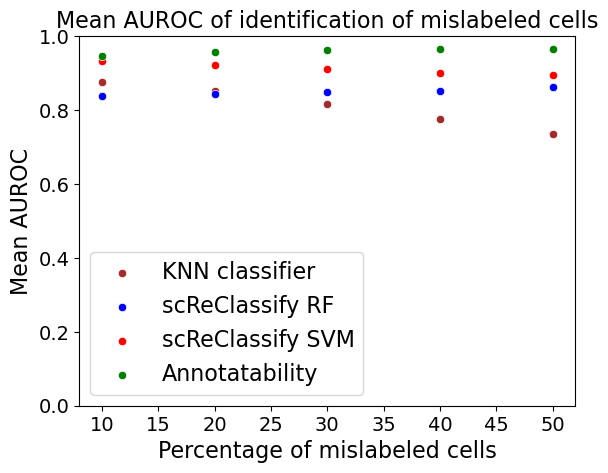

In [23]:
sns.scatterplot(np.arange(1,6)*0.1*100, screc_res_list_knn, color='brown',label='KNN classifier')
sns.scatterplot(np.arange(1,6)*0.1*100, screc_res_list_rf, color='b',label='scReClassify RF')
sns.scatterplot(np.arange(1,6)*0.1*100, screc_res_list_svm, color='r',label='scReClassify SVM')
sns.scatterplot(np.arange(1,6)*0.1*100, cell_anno_list, color='g',label='Annotatability')
plt.ylim([0,1])
plt.title("Mean AUROC of identification of mislabeled cells", fontsize=16)
plt.xlabel("Percentage of mislabeled cells", fontsize=16)
plt.ylabel("Mean AUROC", fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [24]:
print(screc_res_list_knn)
print()
print(screc_res_list_rf)
print()
print(screc_res_list_svm)
print()
print(cell_anno_list)

[0.8748418277419969, 0.8504263448334337, 0.8159032729225244, 0.7758543100401358, 0.736309525095139]

[0.8370264354257421, 0.8435565338589879, 0.848192907364975, 0.8510696032324638, 0.8632656420728753]

[0.9314100933292041, 0.9225738398451258, 0.9116713790121326, 0.9008022234796984, 0.8945575993027916]

[0.9467675332566792, 0.9568368701981094, 0.962862314333444, 0.9654534478385374, 0.9658578256879229]
